# EXTENDED FIGURE 11 Revision

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import cloudvolume
from caveclient import CAVEclient
import nglui
from statistics import mean
import matplotlib.pyplot as plt

#client = CAVEclient('minnie65_phase3_v1')
#client.info.get_datastack_info()

In [2]:
#Load dataframe
synapse_table = pd.read_feather("ET_Column_synapse_table_revision.feather")

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
synapse_table.head()

,synapse_id,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_mesh_ind_filt,dist_to_root,distance_rank,pre_nucleus_id,post_nucleus_id,post_soma_pt,NEURD_class,metamodel_class,metamodel_cell_type,mtypes_model_cell_type,mtypes_column,motif_group,post_soma_area,pre_soma_pt,pre_soma_area,manual_class_original,manual_subclass_original,num_soma,inhibitory_groups,manual_subclass,manual_class,consensus_class,consensus_subclass,orphan
0,119648357,11732,86011221899392293,864691136313000765,86011221899388242,864691135848920670,"[154430, 214570, 20104]","[154432, 214682, 20097]","[154418, 214622, 20098]",158068815937143048,1689,1689,187341.750702,97.0,267008,266505.0,"[166240, 199152, 18693]",inhibitory,excitatory,5P-IT,5P-IT,5P-IT,NaN,v1,"[169216, 196416, 20820]",v1,None,None,1.0,0,MC,inhibitory,inhibitory,MC,None
1,142105984,4240,87700759222750941,864691136313000765,87700759222754045,864691136445206659,"[166608, 219504, 22041]","[166580, 219466, 22041]","[166638, 219484, 22040]",159758353260609612,5194,5194,182533.041931,90.5,267008,303374.0,"[182464, 208704, 24245]",inhibitory,inhibitory,MC,DTC,None,NaN,v1,"[169216, 196416, 20820]",v1,None,None,1.0,0,MC,inhibitory,inhibitory,MC,None
2,134843766,8100,86855646896563989,864691136313000765,86925946921252564,864691134886001146,"[160726, 214240, 20539]","[160824, 214178, 20534]","[160788, 214224, 20539]",158913240934383726,3073,3073,149581.132599,44.0,267008,339621.0,"[197744, 220592, 20239]",excitatory,excitatory,6P,6P,6P,NaN,v1,"[169216, 196416, 20820]",v1,excitatory,None,1.0,0,None,excitatory,excitatory,6P,None
3,149187416,8944,88193683962697971,864691136313000765,88193615243236556,864691135570610566,"[170318, 221910, 21912]","[170332, 221832, 21921]","[170316, 221875, 21920]",160251278000128507,6418,6418,161279.000275,59.0,267008,306958.0,"[181136, 229072, 22344]",excitatory,excitatory,6P,6P,6P,NaN,v1,"[169216, 196416, 20820]",v1,excitatory,None,1.0,0,None,excitatory,excitatory,6P,None
4,142257444,5844,87559471978907523,864691136313000765,87559471978912697,864691135585266808,"[165726, 215452, 22360]","[165702, 215404, 22361]","[165734, 215406, 22365]",159617066016440934,4874,4874,165806.229675,67.0,267008,302957.0,"[183456, 202752, 20953]",None,excitatory,5P-ET,5P-ET,5P-ET,NaN,v1,"[169216, 196416, 20820]",v1,None,None,1.0,0,None,None,excitatory,5P-ET,None


In [4]:
synapse_table.consensus_subclass.unique()

array(['MC', '6P', '5P-ET', None, 'BC', '5P-IT', 'BPC', '5P-NP', '23P',
       'NGC', '4P'], dtype=object)

In [5]:
#MAKE STATS DATAFRAME - All synapses and connections

#get ET neurons root IDs
All_neurons = synapse_table.pre_pt_root_id.unique()
print('number of ET neurons: ',len(All_neurons))

#'y' location of cortical surface
surface_y_column =[84534, 85689, 86053, 87800, 89421, 90105, 82884, 81677, 86242]
average_surface_location = mean(surface_y_column)


#Create Dataframe

np.seterr(divide='ignore', invalid='ignore')

percentage = []
values = []

#IDs of presynaptic PT neurons
pre_soma_IDs = All_neurons


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
    pre_nucleus_ID = synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID)].pre_nucleus_id.unique().item(),
                    
    
    stat_values={

                    'ID': pre_soma_ID,
                    'nucleus_ID':  pre_nucleus_ID[0],
                    
    #SYNAPSES
                    
                    'all_syn_total': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
                    'all_e_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]),
                    'all_i_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]),
        
                    'all_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]),
                    
        
                    'all_23P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]),
        
                    'all_4P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]),
                    'all_5P-ET_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]),
                    'all_5P-NP_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]), 
                    'all_5P-IT_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]), 
                
                    'all_6P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]),
        
                    'all_BC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]),
        
                    'all_MC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]),
        
                    'all_BPC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]),
        
                    'all_NGC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]),
        
                    'all_Undetermined_subclass_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]),
                    
        
        #CONNECTIONS
                    'all_con_total': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]
                                         ['post_pt_root_id'].unique()),
                    
                    'all_e_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]
                                      ['post_pt_root_id'].unique()),
                    
                    'all_i_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]
                                      ['post_pt_root_id'].unique()),
        
                    'all_Undetermined_class_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]['post_pt_root_id'].unique()),                      
        
                    'all_23P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]['post_pt_root_id'].unique()),
        
                    'all_4P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]['post_pt_root_id'].unique()),
                    
                    'all_5P-ET_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]['post_pt_root_id'].unique()),
                    
                    'all_5P-NP_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]['post_pt_root_id'].unique()), 
 
                    'all_5P-IT_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_6P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]['post_pt_root_id'].unique()),
                                    
                    'all_BC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]['post_pt_root_id'].unique()),
                     
                    'all_MC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]['post_pt_root_id'].unique()),
       
                    'all_BPC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]['post_pt_root_id'].unique()),
                    
                    'all_NGC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]['post_pt_root_id'].unique()),
        
                    'all_Undetermined_subclass_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]['post_pt_root_id'].unique()),
                        
        
    }
    values.append(stat_values)
    
    
    stat_percentage={

                    'ID': pre_soma_ID,
                    'nucleus_ID':  pre_nucleus_ID[0],
                    
#                    'Soma_depth':  (client.materialize.query_table('nucleus_detection_v0', filter_equal_dict={'id':pre_nucleus_ID[0]})['pt_position'].apply(lambda x: x[1]).iloc[0]- average_surface_location)*0.004,
                   
                      
                    'i_syn': stat_values['all_i_syn#'] / stat_values['all_syn_total'],
                    'e_syn': stat_values['all_e_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_class_syn': stat_values['all_Undetermined_class_syn#'] / stat_values['all_syn_total'],
        
                    '23P_syn': stat_values['all_23P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '4P_syn': stat_values['all_4P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-ET_syn': stat_values['all_5P-ET_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-IT_syn': stat_values['all_5P-IT_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-NP_syn': stat_values['all_5P-NP_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '6P_syn': stat_values['all_6P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'BC_syn': stat_values['all_BC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'MC_syn': stat_values['all_MC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'BPC_syn': stat_values['all_BPC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'NGC_syn': stat_values['all_NGC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'Undetermined_subclass_syn': stat_values['all_Undetermined_subclass_syn#'] / stat_values['all_syn_total'],
        
        
                    'i_con': stat_values['all_i_con#'] / stat_values['all_con_total'],
                    'e_con': stat_values['all_e_con#'] / stat_values['all_con_total'],
                    'Undetermined_class_con': stat_values['all_Undetermined_class_con#'] / stat_values['all_con_total'],
                   
        
                    '23P_con': stat_values['all_23P_con#'] / stat_values['all_con_total'],
                    '4P_con': stat_values['all_4P_con#'] / stat_values['all_con_total'],
                    '5P-ET_con': stat_values['all_5P-ET_con#'] / stat_values['all_con_total'],
                    '5P-IT_con': stat_values['all_5P-IT_con#'] / stat_values['all_con_total'],
                    '5P-NP_con': stat_values['all_5P-NP_con#'] / stat_values['all_con_total'],
                    '6P_con': stat_values['all_6P_con#'] / stat_values['all_con_total'],
                    'BC_con': stat_values['all_BC_con#'] / stat_values['all_con_total'],
                    'MC_con': stat_values['all_MC_con#'] / stat_values['all_con_total'],
                    'BPC_con': stat_values['all_BPC_con#'] / stat_values['all_syn_total'],
                    'NGC_con': stat_values['all_NGC_con#'] / stat_values['all_con_total'],
                    'Undetermined_subclass_con': stat_values['all_Undetermined_subclass_con#'] / stat_values['all_con_total'],
                   
    }
    percentage.append(stat_percentage) 
    

synapse_table_values = pd.DataFrame(values)
synapse_table_percentage = pd.DataFrame(percentage)

#total_values = pd.DataFrame(synapse_table_values.sum(), columns=parts.columns, index=["Total"])
#stats_type.append(stat)  

number of ET neurons:  39


In [ ]:
synapse_table_percentage

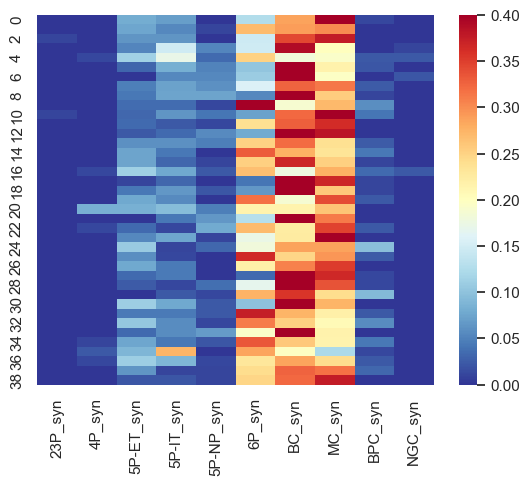

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sorted_synapse_table_percentage = synapse_table_percentage.sort_values(by='BC_syn')
sorted_synapse_table_percentage = synapse_table_percentage



#individual cells
heat_synapse_table = sorted_synapse_table_percentage[['23P_syn','4P_syn','5P-ET_syn','5P-IT_syn','5P-NP_syn','6P_syn','BC_syn','MC_syn','BPC_syn','NGC_syn']]
#heat_synapse_table_E = sorted_synapse_table_percentage[['23P_syn','4P_syn','5P-ET_syn','5P-IT_syn','5P-NP_syn','6P_syn']]
#heat_synapse_table_I = sorted_synapse_table_percentage[['BC_syn','MC_syn','BPC_syn','NGC_syn']]


#total percantages
#short_synapse = synapse_table_values[['all_23P_syn#','all_4P_syn#','all_5P-ET_syn#','all_5P-IT_syn#','all_5P-NP_syn#',
#                                      'all_6P_syn#','all_BC_syn#','all_MC_syn#','all_BPC_syn#','all_NGC_syn#']]
#total_percentages = pd.DataFrame(short_synapse.sum()) / pd.DataFrame(short_synapse.sum()).sum()

sns.set()

ax = sns.heatmap(heat_synapse_table, cmap='RdYlBu_r', vmin=0, vmax=0.40)


plt.savefig("Extended_Fig_11_revision.eps")
plt.show()